In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess

In [2]:
# Load in our data
df = pd.read_csv('Channel_attribution.csv')

# Grab list of columns to iterate through
cols = df.columns

# Iterate through columns to change all ints to str and remove any trailing '.0'
for col in cols:
    df[col] = df[col].astype(str)
    df[col] = df[col].map(lambda x: str(x)[:-2] if '.' in x else str(x))

In [4]:
# Create a total path variable
df['Path'] = ''
for i in df.index:
    #df.at[i, 'Path'] = 'Start'
    for x in cols:
        df.at[i, 'Path'] = df.at[i, 'Path'] + df.at[i, x] + ' > '

In [7]:
# Split path on conversion (channel 21)
df['Path'] = df['Path'].map(lambda x: x.split(' > 21')[0])

# Create conversion value we can sum to get total conversions for each path
df['Conversion'] = 1

In [9]:
# Select relevant columns
df = df[['Path', 'Conversion']]

# Sum conversions by Path
df = df.groupby('Path').sum().reset_index()

# Write DF to CSV to be executed in R
df.to_csv('Paths.csv', index=False)

In [24]:
# Define the path to the R script that will run the Markov Model
path2script = 'C:/Users/Apoorva/Documents/msba resume/Full time applications/capegemini/markov.r'

# Call the R script
subprocess.call(['C:/Program Files/R/R-3.6.1/bin/Rscript', '--vanilla', path2script], shell=True)


1

In [27]:
# Load in the CSV file with the model output from R
markov = pd.read_csv('Markov - Output - Conversion values.csv')

# Select only the necessary columns and rename them
markov = markov[['channel_name', 'total_conversions']]
markov.columns = ['Channel', 'Conversion']

In [28]:
# First Touch Attribution
df['First Touch'] = df['Path'].map(lambda x: x.split(' > ')[0])
df_ft = pd.DataFrame()
df_ft['Channel'] = df['First Touch']
df_ft['Attribution'] = 'First Touch'
df_ft['Conversion'] = 1
df_ft = df_ft.groupby(['Channel', 'Attribution']).sum().reset_index()

# Last Touch Attribution
df['Last Touch'] = df['Path'].map(lambda x: x.split(' > ')[-1])
df_lt = pd.DataFrame()
df_lt['Channel'] = df['Last Touch']
df_lt['Attribution'] = 'Last Touch'
df_lt['Conversion'] = 1
df_lt = df_lt.groupby(['Channel', 'Attribution']).sum().reset_index()

# Linear Attribution
channel = []
conversion = []
for i in df.index:
    for j in df.at[i, 'Path'].split(' > '):
        channel.append(j)
        conversion.append(1/len(df.at[i, 'Path'].split(' > ')))
lin_att_df = pd.DataFrame()
lin_att_df['Channel'] = channel
lin_att_df['Attribution'] = 'Linear'
lin_att_df['Conversion'] = conversion
lin_att_df = lin_att_df.groupby(['Channel', 'Attribution']).sum().reset_index()

C:\Users\Apoorva\Documents\AnacondaInstallation\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


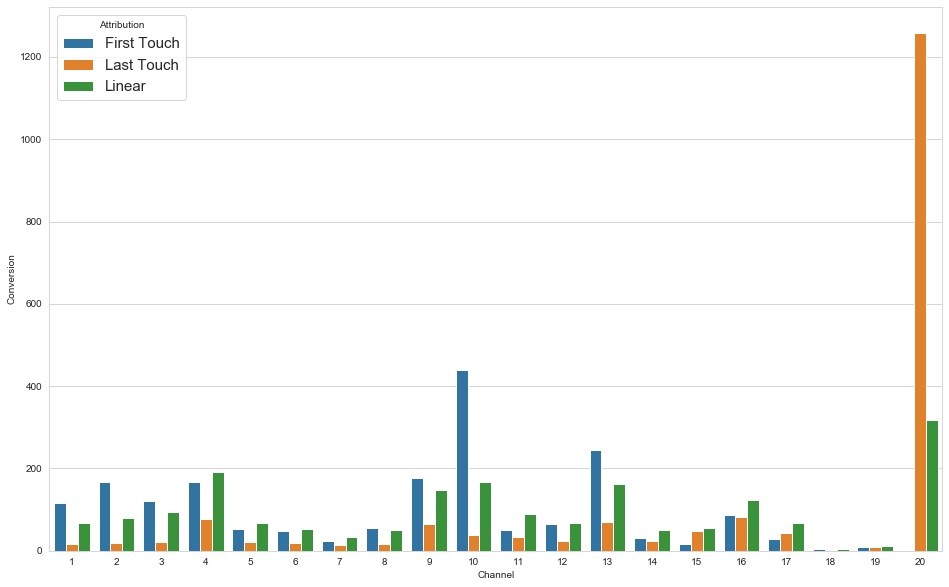

In [32]:
# Concatenate the four data frames to a single data frame
df_total_attr = pd.concat([df_ft, df_lt, lin_att_df, markov])
df_total_attr['Channel'] = df_total_attr['Channel'].astype(int)
df_total_attr.sort_values(by='Channel', ascending=True, inplace=True)


# Visualize the attributions
sns.set_style("whitegrid")
plt.rc('legend', fontsize=15)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x='Channel', y='Conversion', hue='Attribution', data=df_total_attr)
plt.show()

In [33]:
df_total_attr.to_excel("Attribution markov vs others.xlsx")